<a href="https://colab.research.google.com/github/traizooo/TensorFlow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: **Fine-tuning**.

In [ ]:
# Check if we're using a GPU
!nvidia-smi

Sun Mar 26 13:47:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions with used previously here: [helper_functions.py](https://raw.githubusercontent.com/traizooo/TensorFlow/main/helper_functions.py)

In [ ]:
!wget https://raw.githubusercontent.com/traizooo/TensorFlow/main/helper_functions.py

--2023-03-26 13:47:36--  https://raw.githubusercontent.com/traizooo/TensorFlow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2023-03-26 13:47:36 (57.2 MB/s) - ‘helper_functions.py’ saved [10235/10235]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out, Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pre-trained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-03-26 13:47:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.6MB/s    in 8.0s    

2023-03-26 13:47:50 (20.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes

In [ ]:
# Create training and test paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

# Create thresholds for image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.67704086e+01 4.07704086e+01 6.77040815e+00]
   [5.60714302e+01 4.10714302e+01 8.07142830e+00]
   [5.70000000e+01 4.20000000e+01 9.00000000e+00]
   ...
   [9.70000000e+01 1.13000000e+02 1.12000000e+02]
   [9.60714111e+01 1.12071411e+02 1.11071411e+02]
   [9.57704086e+01 1.11770409e+02 1.08770409e+02]]

  [[5.81938782e+01 4.04030609e+01 9.19387817e+00]
   [5.79336739e+01 4.10051003e+01 1.07908173e+01]
   [5.87857132e+01 4.18010178e+01 1.17551022e+01]
   ...
   [9.77857056e+01 1.13785706e+02 1.12785706e+02]
   [9.69336700e+01 1.12933670e+02 1.11933670e+02]
   [9.60000000e+01 1.12000000e+02 1.09000000e+02]]

  [[6.10000000e+01 4.00000000e+01 1.30000000e+01]
   [6.02857170e+01 4.00714302e+01 1.30714283e+01]
   [6.13826523e+01 4.17857132e+01 1.29336739e+01]
   ...
   [9.83367310e+01 1.14000000e+02 1.13168365e+02]
   [9.70714111e+01 1.13071411e+02 1.12071411e+02]
   [9.70000000e+01 1.13000000e+02 1.10000000e+02]]

  ...

  [[1.01214264e+02 9.02142639e+01 5.94999771e+01]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight forward, it runs our layers in sequential order

But functional API gives us more flexibility with our models.

In [ ]:
# Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile model
model_0.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 validation_steps = (0.25 * len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230326-140613
Epoch 1/5
24/24 [==============================] - 22s 260ms/step - loss: 1.9077 - accuracy: 0.4067 - val_loss: 1.3389 - val_accuracy: 0.7312
Epoch 2/5
24/24 [==============================] - 5s 201ms/step - loss: 1.1108 - accuracy: 0.7680 - val_loss: 0.9064 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 4s 165ms/step - loss: 0.7876 - accuracy: 0.8333 - val_loss: 0.6981 - val_accuracy: 0.8719
Epoch 4/5
24/24 [==============================] - 5s 173ms/step - loss: 0.6304 - accuracy: 0.8693 - val_loss: 0.6187 - val_accuracy: 0.8766
Epoch 5/5
24/24 [==============================] - 4s 138ms/step - loss: 0.5521 - accuracy: 0.8760 - val_loss: 0.5547 - val_accuracy: 0.8719


In [ ]:
# Evaluate on full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 73ms/step - loss: 0.5557 - accuracy: 0.8648


[0.555748701095581, 0.864799976348877]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_6
1 rescaling_10
2 normalization_5
3 rescaling_11
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activa

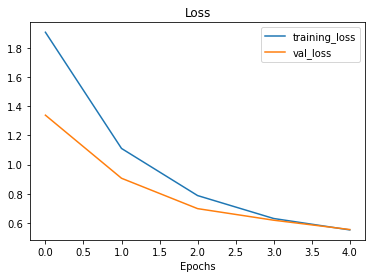

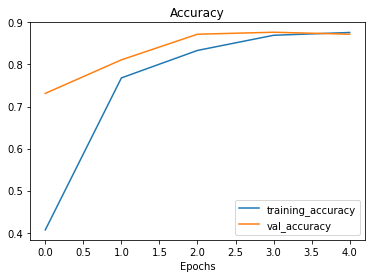

In [ ]:
# Check out our models training curves
plot_loss_curves(history_10_percent)